In [1]:
pip install xwhy

Note: you may need to restart the kernel to use updated packages.


   # Credit Fraud Detector 
   
In this project, we train and evaluate different machine learning models in order to detect potential fraudlent transactions.
The problem we investigate here is to determine if a particular transaction is fraudulent or its a genuine transaction. Then we use SMILE explainabilty technique for Local explaination.

The data is  imbalanced and the genuine transaction (no fraud) class is 99.83%. There is no missing value in the  dataset and the mean of transactions is relatively low. Also, due to privacy and security concerns, the column names are not available, except for the time offset and the transaction amount. It should be noted that all the values except these two columns are already scaled. 

SMILE is a model agnostic explainer which provides local explanations.


References: 
Hands on Machine Learning with Scikit-Learn & TensorFlow by Aurélien Géron (O'Reilly). CopyRight 2017 Aurélien Géron
Machine Learning - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn by Coding-Maniac
auprc, 5-fold c-v, and resampling methods by Jeremy Lane (Kaggle Notebook)

In [231]:
# Imported Libraries

import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [232]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Checking the distribution of Time and Amount

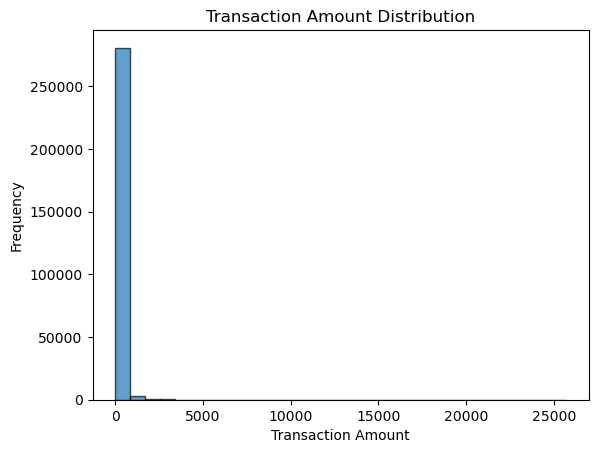

In [233]:
import matplotlib.pyplot as plt

# Assuming 'df' is your dataframe
plt.hist(df['Amount'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()


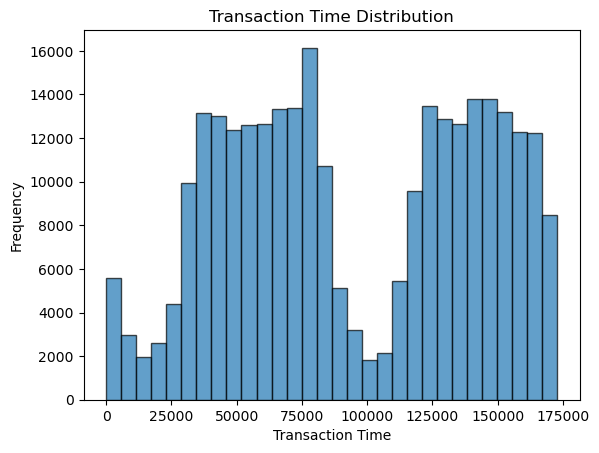

In [235]:
import matplotlib.pyplot as plt

# Assuming 'df' is your dataframe
plt.hist(df['Time'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Transaction Time Distribution')
plt.xlabel('Transaction Time')
plt.ylabel('Frequency')
plt.show()


In [191]:
# Checking for null values
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [192]:
df.shape

(284807, 31)

In [193]:
# Checking for the number of transactions classified as fraud
df_fraud = (df[df['Class'] == 1]).value_counts().sum()

# Let's get the percentage of classified fraud
perc_fraud = df_fraud / len(df) * 100
perc_fraud

0.1727485630620034

In [194]:
# Checking for the number of transactions classified as non-fraud
df_no_fraud = (df[df['Class'] == 0]).value_counts().sum()

# Let's get the percentage of classified fraud
perc_no_fraud = df_no_fraud / len(df) * 100
perc_no_fraud

99.82725143693798

##### According to what we have above, the percentage of fraudulent transactions is 0.172% while those classified as free of fraud is 99.827%.
##### This shows that the data is heavily skewed and imbalanced.

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

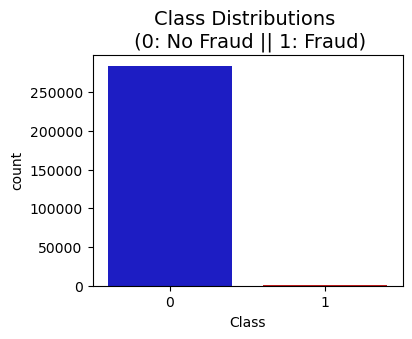

In [195]:
# Visualization of Data distribution
colors = ["#0101DF", "#DF0101"]

plt.figure(figsize=(4, 3))
sns.countplot(x ='Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

Distributions: Figure above shows that the dataset is highly imbalanced and we need to resolve this issue before modeling.

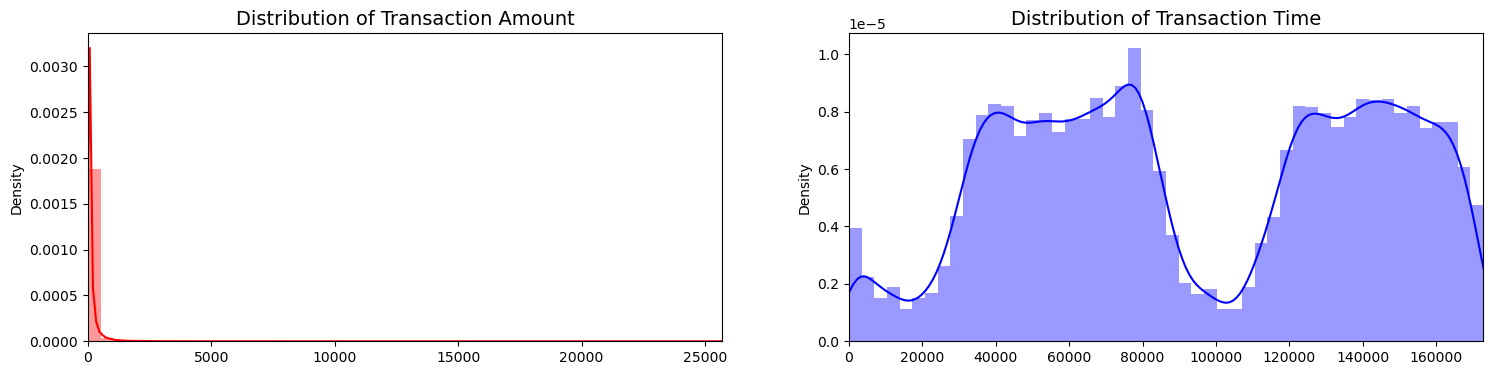

In [196]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r', kde=True)
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b', kde=True)
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()


### These two side-by-side plots shows the distribution of transaction amounts and the distribution of transaction times.

# Now, it is time to scale the columns that have not been scaled already - (Time and Amount)

### We have to create a sample dataframe where we can have an equally matched number of non-fraud cases with the number of fraud cases, and find a way to concatenate it.

In [237]:
#  I will be using RobustScaler because it doesnt follow a particular distribution, and it is more immune to outliers.

from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [238]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)

# Inserting the new scaled columns into the dataframe
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

In [239]:
df

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-0.296653,1.034951,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0
284803,0.038986,1.034963,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0
284804,0.641096,1.034975,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0
284805,-0.167680,1.034975,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0


In [200]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['Class'])
y = df['Class']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [201]:
# Display the splits

print("X_train:\n", X_train)
print("X_test:\n", X_test)
print("y_train:\n", y_train)
print("y_test:\n", y_test)

X_train:
         scaled_amount  scaled_time        V1        V2        V3        V4  \
223361      -0.167819     0.689153  1.955041 -0.380783 -0.315013  0.330155   
165061       0.333962     0.381595 -0.400975 -0.626943  1.555339 -2.017772   
238186      -0.139873     0.762145  0.072509  0.820566 -0.561351 -0.709897   
150562       1.333613     0.105476 -0.535045  1.014587  1.750679  2.769390   
138452       0.052540    -0.023931 -4.026938  1.897371 -0.429786 -0.029571   
...               ...          ...       ...       ...       ...       ...   
119879      -0.279746    -0.106604  1.173488  0.100792  0.490512  0.461596   
259178       0.939426     0.872990 -0.775981  0.144023 -1.142399 -1.241113   
131932      -0.252358    -0.057531 -0.146609  0.992946  1.524591  0.485774   
146867      -0.293440     0.038053 -2.948638  2.354849 -2.521201 -3.798905   
121958       1.271571    -0.097640  1.233174 -0.784851  0.386784 -0.698559   

              V5        V6        V7        V8  ...  

In [202]:
train_unique_label, train_counts_label = np.unique(y_train, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_test, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(y_train))
print(test_counts_label/ len(y_test))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827075 0.00172925]
[0.99827955 0.00172045]


## To have a more balanced dataset, in order to avoid having an overfit model, we must do random under sampling (randomly removing data)



In [203]:
from imblearn.under_sampling import RandomUnderSampler
# Performing random undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Display the results
print("Original training set class distribution:\n", y.value_counts())
print("Resampled training set class distribution:\n", y_resampled.value_counts())

# Converting resampled data back to DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['Class'] = y_resampled

# Display the resampled DataFrame
print("Resampled DataFrame:\n", df_resampled)

Original training set class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64
Resampled training set class distribution:
 Class
0    492
1    492
Name: count, dtype: int64
Resampled DataFrame:
         scaled_amount  scaled_time        V1        V2        V3        V4  \
138028      -0.296793    -0.026340  1.314539  0.590643 -0.666593  0.716564   
63099       -0.249004    -0.401062 -0.798672  1.185093  0.904547  0.694584   
73411       -0.097813    -0.347361 -0.391128 -0.245540  1.122074 -1.308725   
164247       0.489066     0.374534 -0.060302  1.065093 -0.987421 -0.029567   
148999      -0.307413     0.067458  1.848433  0.373364  0.269272  3.866438   
...               ...          ...       ...       ...       ...       ...   
279863       5.142178     0.992140 -1.927883  1.125653 -4.518331  1.749293   
280143      -0.296793     0.994549  1.378559  1.289381 -5.004247  1.411850   
280149       0.780968     0.994596 -0.676143  1.126366 -2.213700  0.468308   
28114

In [204]:
# Checking the created subsamples
df_resampled.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
138028,-0.296793,-0.026340,1.314539,0.590643,-0.666593,0.716564,0.301978,-1.125467,0.388881,-0.288390,...,-0.058040,-0.170307,-0.429655,-0.141341,-0.200195,0.639491,0.399476,-0.034321,0.031692,0
63099,-0.249004,-0.401062,-0.798672,1.185093,0.904547,0.694584,0.219041,-0.319295,0.495236,0.139269,...,-0.081298,0.202287,0.578699,-0.092245,0.013723,-0.246466,-0.380057,-0.396030,-0.112901,0
73411,-0.097813,-0.347361,-0.391128,-0.245540,1.122074,-1.308725,-0.639891,0.008678,-0.701304,-0.027315,...,0.065716,-0.133485,0.117403,-0.191748,-0.488642,-0.309774,0.008100,0.163716,0.239582,0
164247,0.489066,0.374534,-0.060302,1.065093,-0.987421,-0.029567,0.176376,-1.348539,0.775644,0.134843,...,-0.169706,0.355576,0.907570,-0.018454,-0.126269,-0.339923,-0.150285,-0.023634,0.042330,0
148999,-0.307413,0.067458,1.848433,0.373364,0.269272,3.866438,0.088062,0.970447,-0.721945,0.235983,...,-0.282777,0.103563,0.620954,0.197077,0.692392,-0.206530,-0.021328,-0.019823,-0.042682,0


### Now that we have a balanced dataset, we can go further in our analysis and data pre-processing

Distribution of the Classes in the subsample dataset
Class
0    0.5
1    0.5
Name: count, dtype: float64


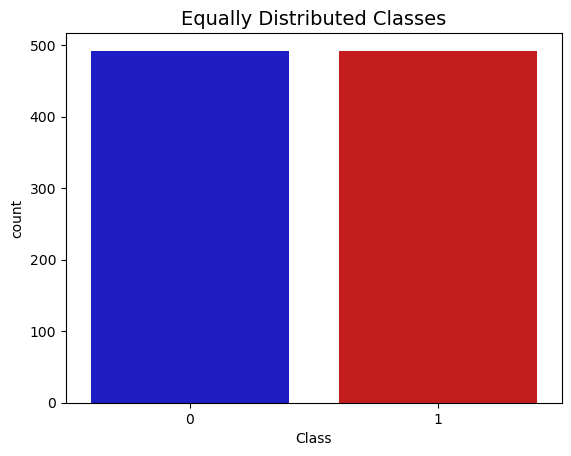

In [205]:
# To check if the dataset is really balanced

print('Distribution of the Classes in the subsample dataset')
print(df_resampled['Class'].value_counts()/len(df_resampled))



sns.countplot(x= 'Class', data=df_resampled, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

###  Let us check for correllation among the features

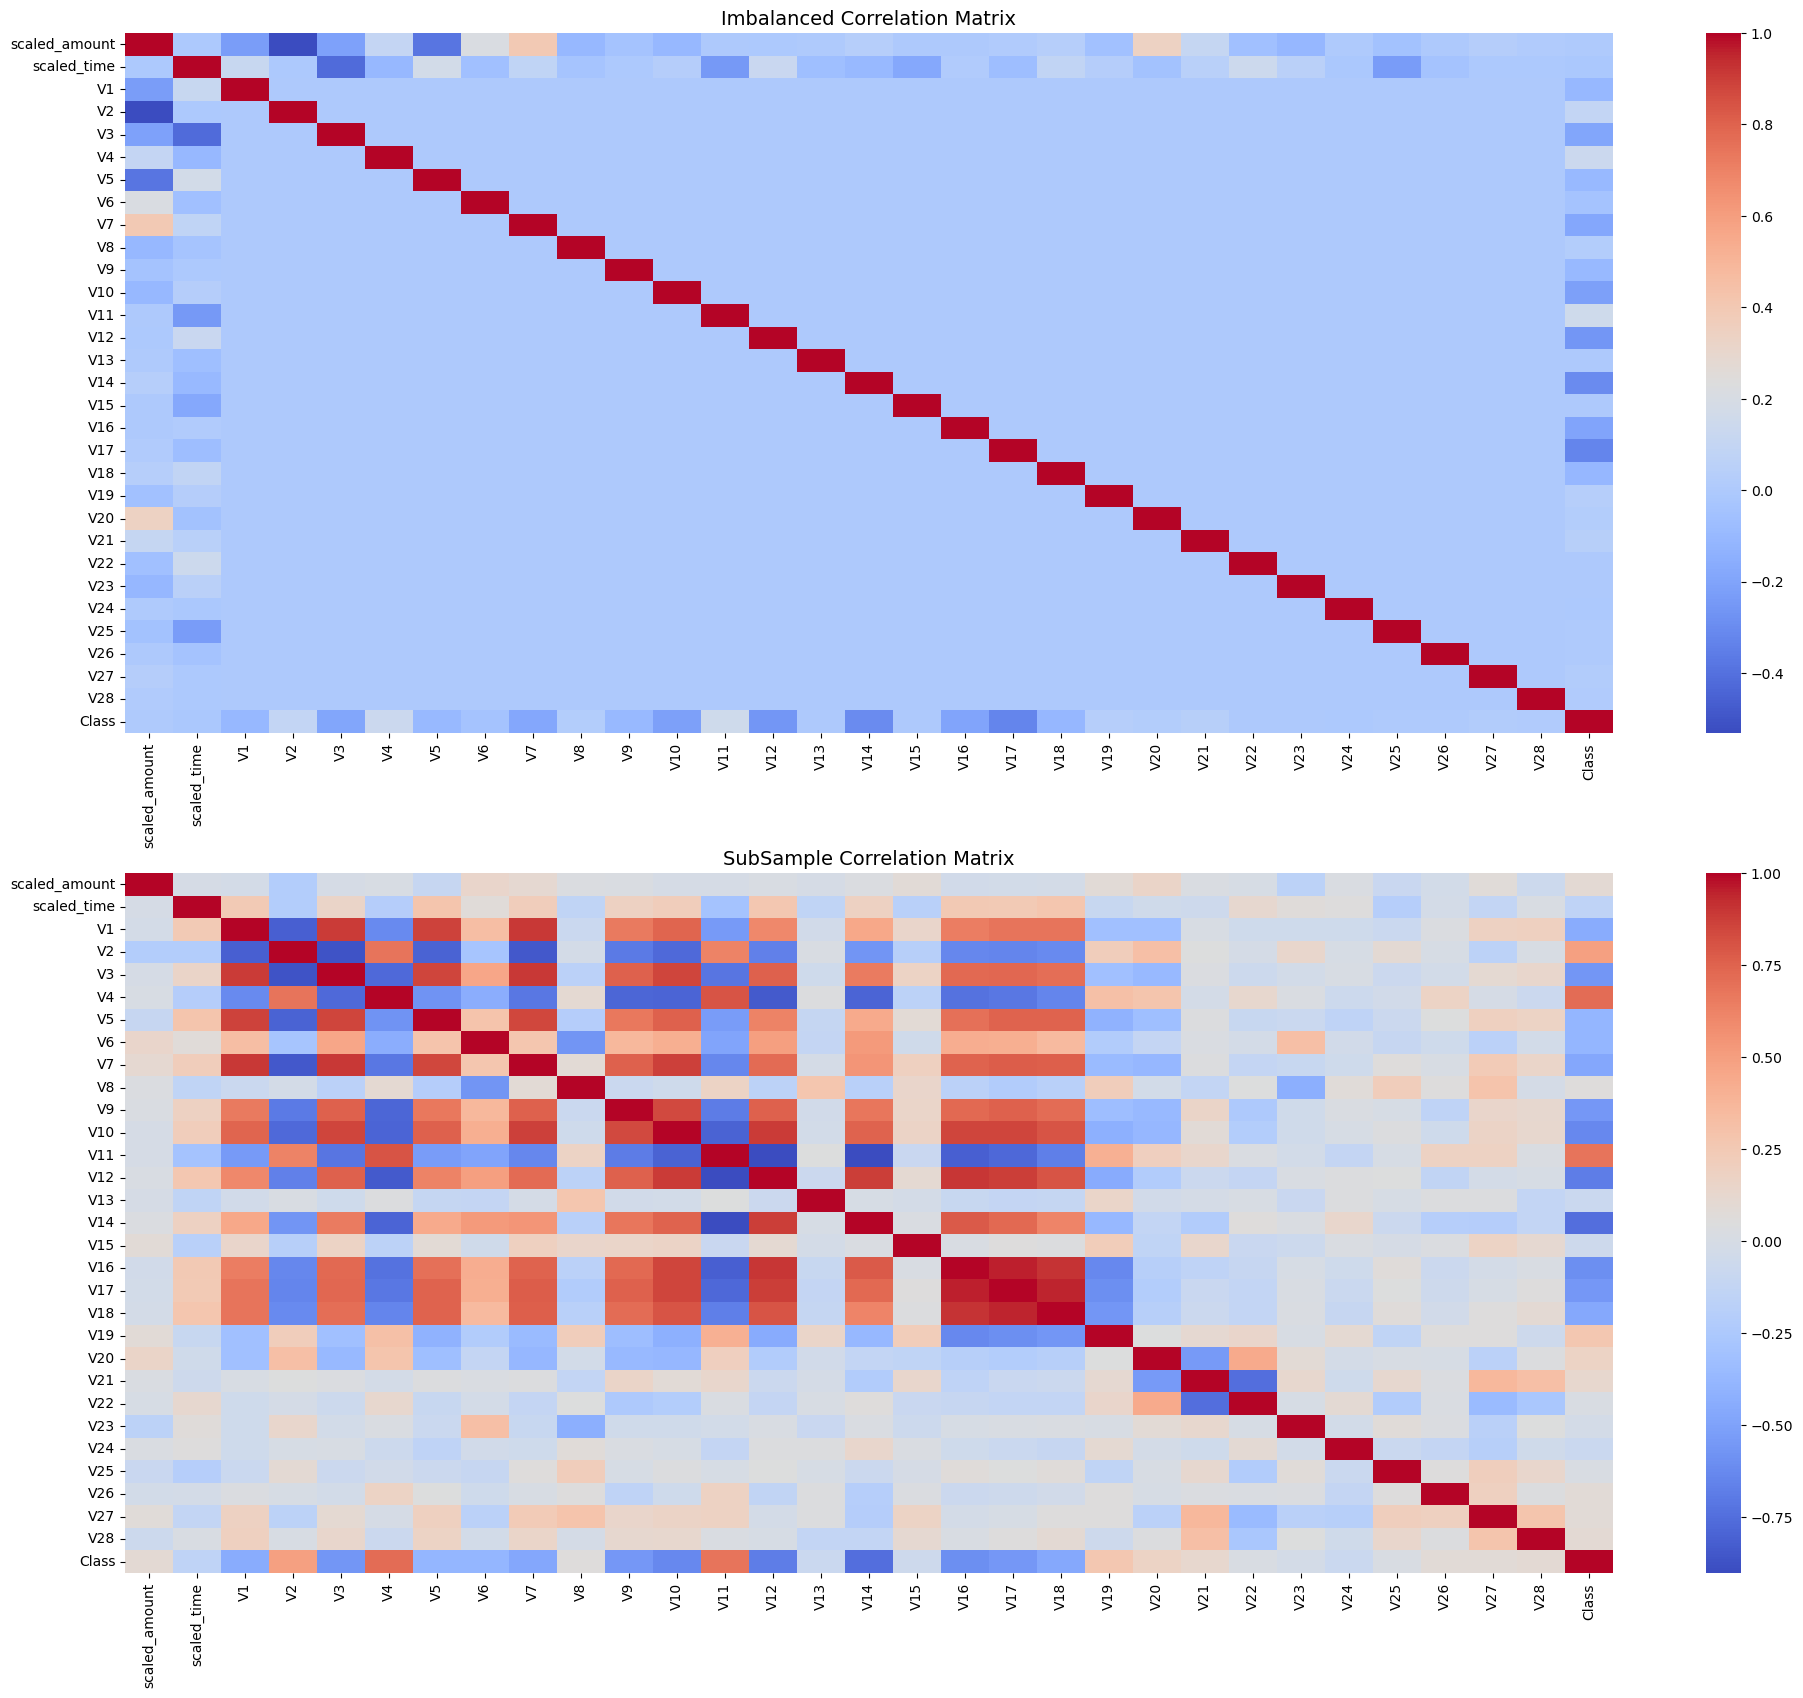

In [206]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)


sub_sample_corr = df_resampled.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix', fontsize=14)

plt.show()

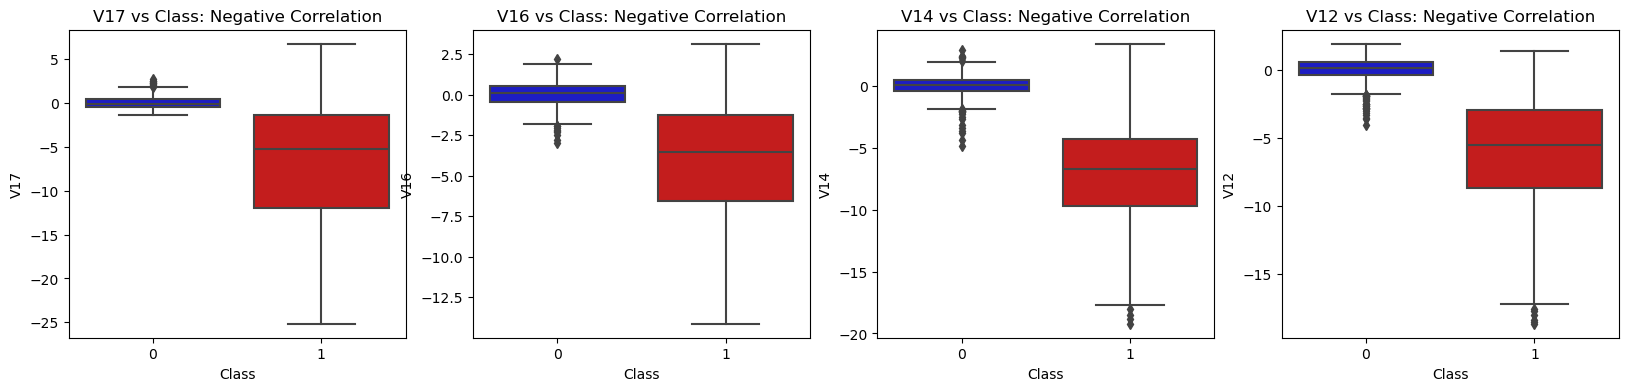

In [207]:
#  Visualizing the negative correllations between the features

fig, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The farther the color on the heatmap is from red, the less likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=df_resampled, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class: Negative Correlation')

sns.boxplot(x="Class", y="V16", data=df_resampled, palette=colors, ax=axes[1])
axes[1].set_title('V16 vs Class: Negative Correlation')

sns.boxplot(x="Class", y="V14", data=df_resampled, palette=colors, ax=axes[2])
axes[2].set_title('V14 vs Class: Negative Correlation')


sns.boxplot(x="Class", y="V12", data=df_resampled, palette=colors, ax=axes[3])
axes[3].set_title('V12 vs Class: Negative Correlation')


plt.show()

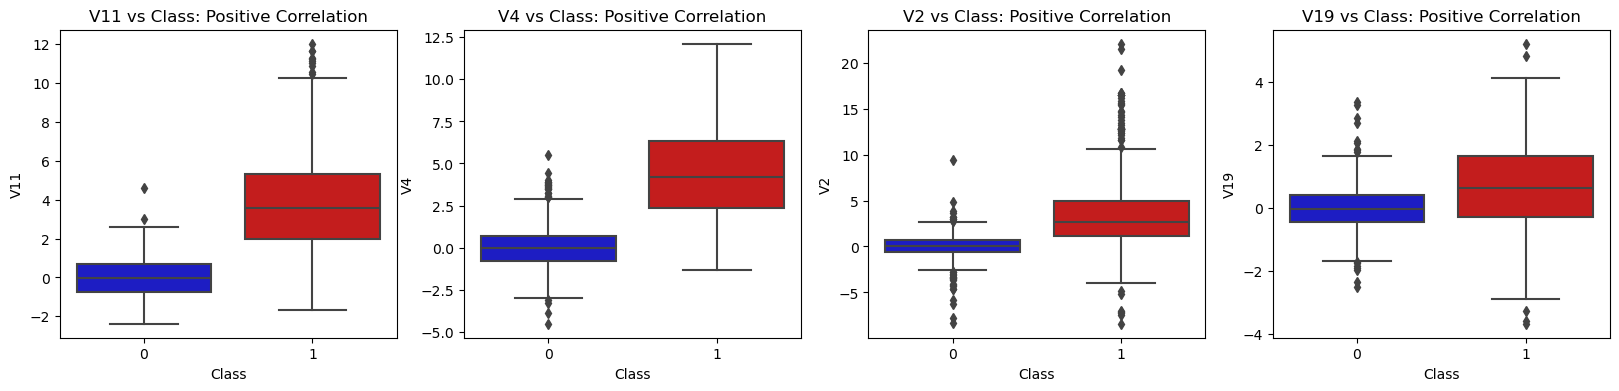

In [208]:
fig, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The closer the color on the heatmap is to red, the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=df_resampled, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class: Positive Correlation')

sns.boxplot(x="Class", y="V4", data=df_resampled, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class: Positive Correlation')


sns.boxplot(x="Class", y="V2", data=df_resampled, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class: Positive Correlation')


sns.boxplot(x="Class", y="V19", data=df_resampled, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class: Positive Correlation')

plt.show()

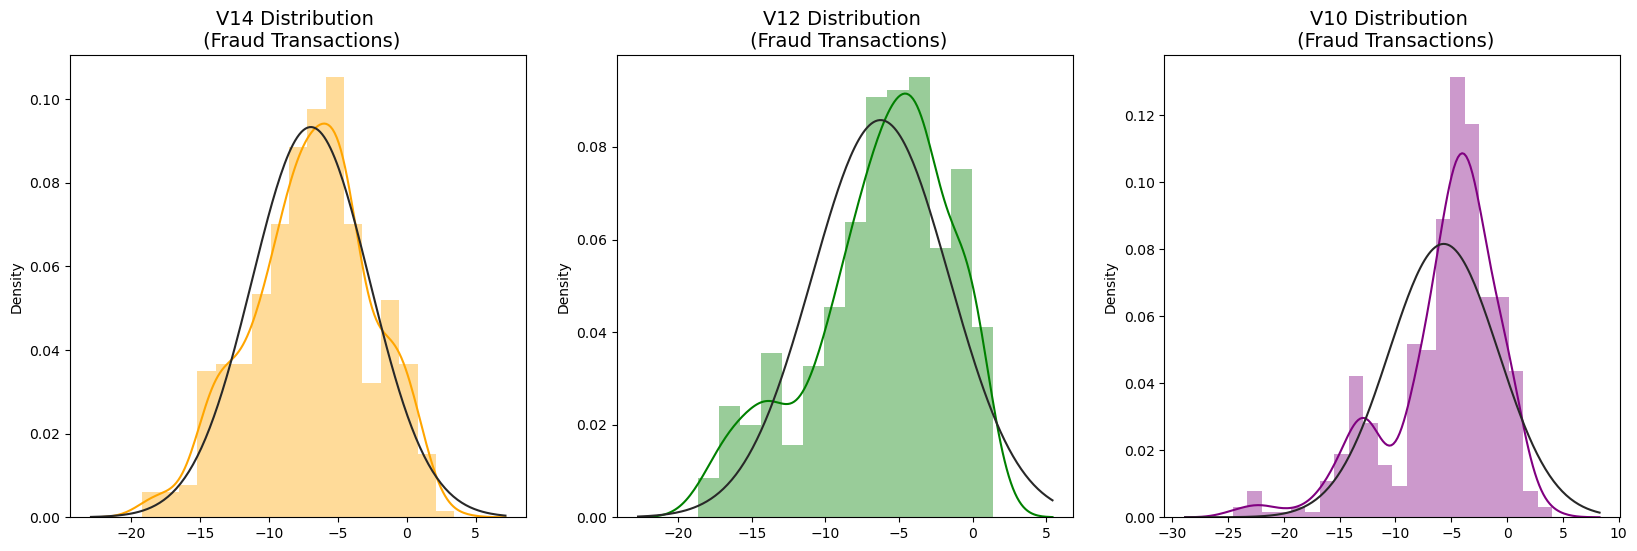

In [209]:
#  Showing the distribution of fraud transactions

from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = df_resampled['V14'].loc[df_resampled['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='orange')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = df_resampled['V12'].loc[df_resampled['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='green')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = df_resampled['V10'].loc[df_resampled['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='purple')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [210]:
# Removing outliers using Z-score

from scipy.stats import zscore
 # Calculate the z-scores of each column
z_scores = np.abs(zscore(df_resampled[['V14', 'V12', 'V10']]))

# Define a threshold for identifying outliers
threshold = 3

# Identify rows where the z-score is greater than the threshold
outliers = (z_scores > threshold).any(axis=1)

# Remove the outliers
df_no_outliers = df_resampled[~outliers]

print("Data with outliers removed using z-score method:")
print(df_no_outliers)

Data with outliers removed using z-score method:
        scaled_amount  scaled_time        V1        V2        V3        V4  \
138028      -0.296793    -0.026340  1.314539  0.590643 -0.666593  0.716564   
63099       -0.249004    -0.401062 -0.798672  1.185093  0.904547  0.694584   
73411       -0.097813    -0.347361 -0.391128 -0.245540  1.122074 -1.308725   
164247       0.489066     0.374534 -0.060302  1.065093 -0.987421 -0.029567   
148999      -0.307413     0.067458  1.848433  0.373364  0.269272  3.866438   
...               ...          ...       ...       ...       ...       ...   
279863       5.142178     0.992140 -1.927883  1.125653 -4.518331  1.749293   
280143      -0.296793     0.994549  1.378559  1.289381 -5.004247  1.411850   
280149       0.780968     0.994596 -0.676143  1.126366 -2.213700  0.468308   
281144       3.116048     1.001821 -3.113832  0.585864 -5.399730  1.817092   
281674       0.286872     1.006309  1.991976  0.158476 -2.583441  0.408670   

              

In [211]:
# Define a function to remove outliers based on the IQR method

def remove_outliers_iqr(df_resampled, columns = ['V14', 'V12', 'V10']):
    Q1 = df_resampled[columns].quantile(0.25)
    Q3 = df_resampled[columns].quantile(0.75)
    IQR = Q3 - Q1
    filter = (df_resampled[columns] >= (Q1 - 1.5 * IQR)) & (df_resampled[columns] <= (Q3 + 1.5 * IQR))
    return df_resampled[filter.all(axis=1)]

# Remove outliers from specified columns
df_no_outliers_iqr = remove_outliers_iqr(df_resampled, ['V14', 'V12', 'V10'])

print("Data with outliers removed using IQR method:")
print(df_no_outliers_iqr)

Data with outliers removed using IQR method:
        scaled_amount  scaled_time        V1        V2        V3        V4  \
138028      -0.296793    -0.026340  1.314539  0.590643 -0.666593  0.716564   
63099       -0.249004    -0.401062 -0.798672  1.185093  0.904547  0.694584   
73411       -0.097813    -0.347361 -0.391128 -0.245540  1.122074 -1.308725   
164247       0.489066     0.374534 -0.060302  1.065093 -0.987421 -0.029567   
148999      -0.307413     0.067458  1.848433  0.373364  0.269272  3.866438   
...               ...          ...       ...       ...       ...       ...   
279863       5.142178     0.992140 -1.927883  1.125653 -4.518331  1.749293   
280143      -0.296793     0.994549  1.378559  1.289381 -5.004247  1.411850   
280149       0.780968     0.994596 -0.676143  1.126366 -2.213700  0.468308   
281144       3.116048     1.001821 -3.113832  0.585864 -5.399730  1.817092   
281674       0.286872     1.006309  1.991976  0.158476 -2.583441  0.408670   

              V5  

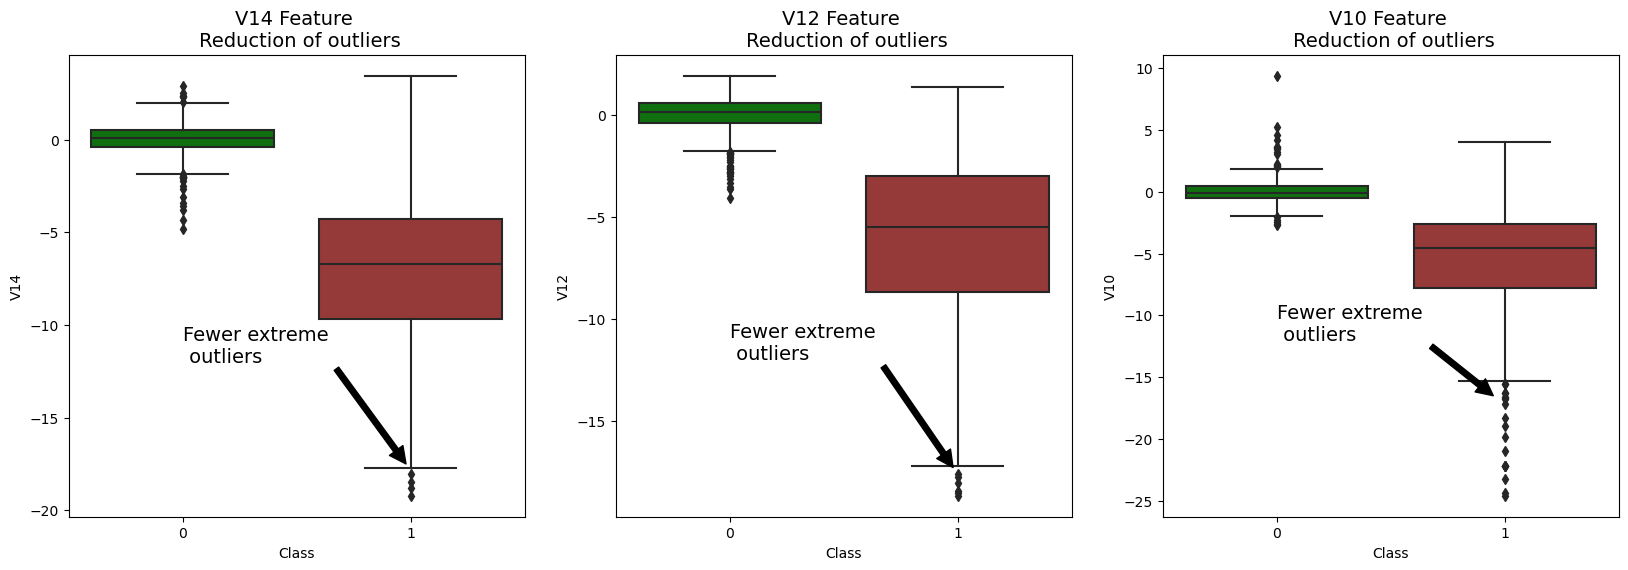

In [213]:
fig,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['green', 'brown']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=df_resampled,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=df_resampled, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=df_resampled, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

## Now that all the columns have been scaled, let us try splitting the resampled data into test and train units

In [214]:
# df_resampled is from the random undersample data (fewer instances)
from sklearn.model_selection import train_test_split

X_resampled = df_resampled.drop('Class', axis=1)
y_resampled = df_resampled['Class']

# Splitting the data into training and testing sets
X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


### For improved model performance, let us try dimensionality reduction using PCA

In [215]:

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X_resampled.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))
  

PCA took 0.027 s


# Time to build our Model

In [216]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_resampled_train, y_resampled_train)

RandomForestClassifier(random_state=42)

In [217]:
# Predicting on the test set
y_pred = rf.predict(X_resampled_test)
y_pred

array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1],
      dtype=int64)

In [218]:
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
import numpy as np

# Check lengths of input arrays
print("Length of X_resampled_train:", len(X_resampled_train))
print("Length of y_resampled_train:", len(y_resampled_train))
print("Length of X_resampled_test:", len(X_resampled_test))
print("Length of y_resampled_test:", len(y_resampled_test))

# Ensure the training data and labels have the same length
if len(X_resampled_train) == len(y_resampled_train):
    # Make predictions using the test dataset
    y_pred = rf.predict(X_resampled_test)

    # Evaluate the model
    print("Confusion Matrix:")
    print(confusion_matrix(y_resampled_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_resampled_test, y_pred))

    # Calculate RMSE using the training data
    y_train_pred = rf.predict(X_resampled_train)
    rmse = np.sqrt(mean_squared_error(y_resampled_train, y_train_pred))
    print("Root Mean Squared Error (RMSE) on training data:", rmse)
else:
    print("Mismatch in number of samples between X_resampled_train and y_resampled_train.")


Length of X_resampled_train: 787
Length of y_resampled_train: 787
Length of X_resampled_test: 197
Length of y_resampled_test: 197
Confusion Matrix:
[[94  5]
 [10 88]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        99
           1       0.95      0.90      0.92        98

    accuracy                           0.92       197
   macro avg       0.93      0.92      0.92       197
weighted avg       0.92      0.92      0.92       197

Root Mean Squared Error (RMSE) on training data: 0.0


True Negatives (TN): 94 (Number of non-fraudulent transactions correctly predicted)

False Positives (FP): 5 (Number of non-fraudulent transactions incorrectly predicted as fraudulent)

False Negatives (FN): 10 (Number of fraudulent transactions incorrectly predicted as non-fraudulent)

True Positives (TP): 88 (Number of fraudulent transactions correctly predicted)

Precision and Recall: The precision and recall for both classes are quite balanced, indicating that the model is doing well 
at distinguishing between fraudulent and non-fraudulent transactions.

F1-score: The F1-scores are high for both classes, which is a good indicator of the model’s performance, especially in imbalanced datasets.

### Trying to get AUPRC for the original Dataset, not the resampled data with Random Forest

In [240]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
# Calculate precision-recall curve
y_scores = rf.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate AUPRC
area = auc(recall, precision)
average_precision = average_precision_score(y_test, y_scores)

print(f"AUPRC (Area Under the Precision-Recall Curve): {area}")
print(f"Average Precision Score: {average_precision}")

AUPRC (Area Under the Precision-Recall Curve): 0.8304760277255345
Average Precision Score: 0.792251367131681


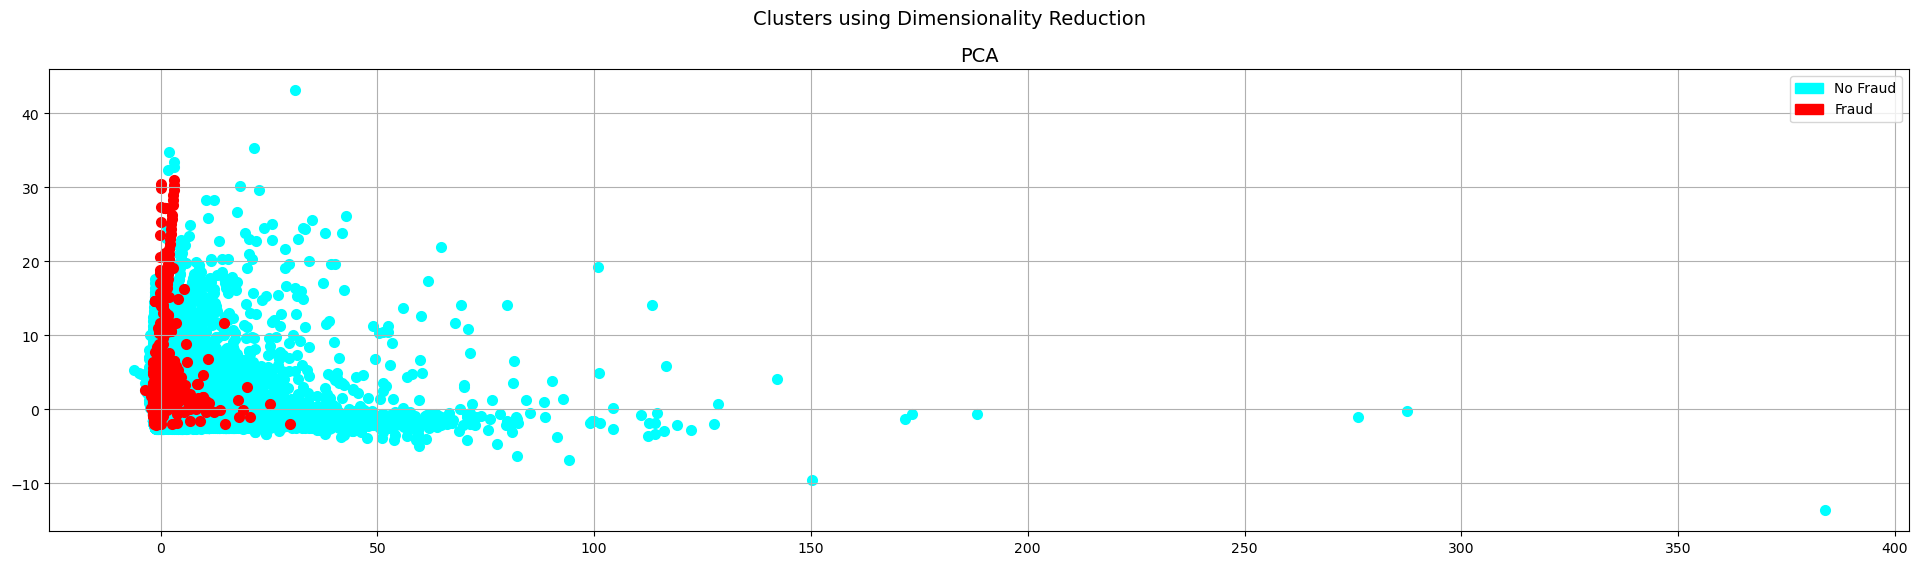

In [219]:
# PCA projection to 2D
pca = PCA(n_components=2)
X_reduced_pca = pca.fit_transform(X)

# Creating a figure and a single axis
fig, ax = plt.subplots(1, 1, figsize=(24, 6))
fig.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

# Defining color patches for the legend
cyan_patch = mpatches.Patch(color='cyan', label='No Fraud')
red_patch = mpatches.Patch(color='red', label='Fraud')

# Plotting the PCA scatter plot
# Separate the points based on the class
no_fraud = ax.scatter(X_reduced_pca[y == 0, 0], X_reduced_pca[y == 0, 1], c='cyan', label='No Fraud', linewidths=2)
fraud = ax.scatter(X_reduced_pca[y == 1, 0], X_reduced_pca[y == 1, 1], c='red', label='Fraud', linewidths=2)

# Setting the title for the axis
ax.set_title('PCA', fontsize=14)

# Adding grid
ax.grid(True)

# Adding legend
ax.legend(handles=[cyan_patch, red_patch])

# Displaying the plot
plt.show()

In [220]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter = 1000)

clf.fit(X_resampled_train, y_resampled_train)

LogisticRegression(max_iter=1000)

In [221]:
# Predicting on the test set
y_pred = clf.predict(X_resampled_test)
y_pred

array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1],
      dtype=int64)

In [222]:
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
import numpy as np

# Check lengths of input arrays
print("Length of X_resampled_train:", len(X_resampled_train))
print("Length of y_resampled_train:", len(y_resampled_train))
print("Length of X_resampled_test:", len(X_resampled_test))
print("Length of y_resampled_test:", len(y_resampled_test))

# Ensure the training data and labels have the same length
if len(X_resampled_train) == len(y_resampled_train):
    # Make predictions using the test dataset
    y_pred = clf.predict(X_resampled_test)

    # Evaluate the model
    print("Confusion Matrix:")
    print(confusion_matrix(y_resampled_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_resampled_test, y_pred))

    # Calculate RMSE using the training data
    y_train_pred = clf.predict(X_resampled_train)
    rmse = np.sqrt(mean_squared_error(y_resampled_train, y_train_pred))
    print("Root Mean Squared Error (RMSE) on training data:", rmse)
else:
    print("Mismatch in number of samples between X_resampled_train and y_resampled_train.")


Length of X_resampled_train: 787
Length of y_resampled_train: 787
Length of X_resampled_test: 197
Length of y_resampled_test: 197
Confusion Matrix:
[[96  3]
 [12 86]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        99
           1       0.97      0.88      0.92        98

    accuracy                           0.92       197
   macro avg       0.93      0.92      0.92       197
weighted avg       0.93      0.92      0.92       197

Root Mean Squared Error (RMSE) on training data: 0.20164507674589452


### Trying to get AUPRC for the original Dataset, not the resampled data using logistic regression

In [226]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
# Calculate precision-recall curve
y_scores = clf.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate AUPRC
area = auc(recall, precision)
average_precision = average_precision_score(y_test, y_scores)

print(f"AUPRC (Area Under the Precision-Recall Curve): {area}")
print(f"Average Precision Score: {average_precision}")

AUPRC (Area Under the Precision-Recall Curve): 0.6909074049060709
Average Precision Score: 0.6667956650591


### Of course, this shows some heavy imbalance in the data. Now, let's proceed to use the resampled data for the same process.

In [245]:
# Let's do some cross validations


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X_resampled_train, y_resampled_train, cv=5, scoring='accuracy', n_jobs=-1)
cv_scores

array([0.96202532, 0.94936709, 0.91719745, 0.92356688, 0.94904459])

# Interpretability Tool (S.M.I.L.E)

In [144]:
pip install SafeML

Note: you may need to restart the kernel to use updated packages.


In [248]:
import numpy as np
from sklearn.linear_model import LinearRegression
from SafeML.Wasserstein_Dist_PVal import Wasserstein_Dist
import pandas as pd

def WasserstainLIME(X_input, model, feature_names, num_perturb=500, kernel_width2=0.2):
    # Validate inputs
    if not isinstance(X_input, np.ndarray) or X_input.ndim != 2:
        raise TypeError("X_input must be a 2-dimensional numpy array.")
    
    if not isinstance(num_perturb, int):
        raise ValueError("num_perturb must be an integer.")
        
    if not np.isscalar(kernel_width2):
        raise ValueError("kernel_width2 must be a scalar.")
    
    n_features = len(feature_names)
    
    # Generate perturbed data
    X_lime = np.random.normal(0, 1, size=(num_perturb, n_features))
    
    # Generate baseline perturbations
    Xi2 = np.zeros((100, n_features))
    Xi2[:, :2] = X_input[0, :2] + np.random.normal(0, 0.05, (100, 2))

    y_lime2  = np.zeros((num_perturb, 1))
    WD       = np.zeros((num_perturb, 1))
    weights2 = np.zeros((num_perturb, 1))

    # Placeholder DataFrame for predictions with correct feature names
    df = pd.DataFrame(np.zeros((100, n_features)), columns=feature_names)

    for ind, ii in enumerate(X_lime):
        temp1 = ii[0] + np.random.normal(0, 0.4, 100)
        temp2 = ii[1] + np.random.normal(0, 0.4, 100)
        
        df["V1"] = temp1
        df["V2"] = temp2
        
        temp3 = model.predict(df)
        y_lime2[ind] = np.argmax(np.bincount(temp3))
        
        WD1 = Wasserstein_Dist(Xi2[:, 0], df["V1"])
        WD2 = Wasserstein_Dist(Xi2[:, 1], df["V2"])
        
        WD[ind] = sum([WD1, WD2])
        weights2[ind] = np.sqrt(np.exp(-(WD[ind]**2) / (kernel_width2**2))) 

    weights2 = weights2.flatten()
    
    # Fit the simpler linear model
    simpler_model2 = LinearRegression() 
    simpler_model2.fit(X_lime, y_lime2, sample_weight=weights2)
    y_linmodel2 = simpler_model2.predict(X_lime)
    
    y_linmodel2 = (y_linmodel2 < 0.5).flatten()
    
    return X_lime, y_lime2, weights2, y_linmodel2, simpler_model2.coef_.flatten()


# Assuming rf is your trained RandomForestClassifier model
rf = RandomForestClassifier()
rf.fit(X_resampled_train, y_resampled_train)
feature_names = X_resampled_train.columns

X_input = np.array([[0.2, 1.5] + [0] * (len(feature_names) - 2)])  # Ensure X_input has the correct number of features

X_lime, y_lime2, weights2, y_linmodel2, coefs = WasserstainLIME(X_input, rf, feature_names)

# Print explanations
print("\nWeights of each perturbation (weights2):")
print(weights2)
print("\nCoefficients of the linear regression model:")
print(coefs)
print("\nPredictions of the linear regression model (y_linmodel2):")
print(y_linmodel2)



Weights of each perturbation (weights2):
[8.68275583e-158 2.73346999e-004 6.62654578e-021 4.08325746e-005
 6.13016030e-018 8.60662751e-117 4.58959722e-099 1.66689803e-084
 1.73032839e-022 4.57249305e-033 1.33177476e-017 1.34173730e-050
 6.83549594e-032 1.63905823e-026 4.32370835e-005 1.31731997e-038
 5.39583985e-077 1.98026752e-052 6.58580130e-078 2.43718726e-012
 2.91749626e-022 4.56195129e-025 2.41241281e-062 1.41051221e-023
 9.77869598e-090 1.62927737e-037 6.07844326e-060 1.12801949e-048
 2.07333636e-008 3.05308196e-033 1.36018341e-015 1.11706717e-021
 7.01011098e-110 5.08424417e-030 9.20807740e-022 1.45945045e-025
 3.62360742e-050 2.06026199e-012 9.96904095e-036 2.17360639e-128
 3.02838082e-003 5.12107795e-017 6.18212332e-056 0.00000000e+000
 1.83738038e-099 1.59420920e-011 1.60970119e-005 6.76960341e-015
 1.95174020e-024 8.90949876e-084 4.27567655e-030 1.46683748e-028
 3.98152938e-036 1.09408074e-041 4.59673108e-034 2.83346018e-037
 1.58780170e-008 2.31336547e-024 8.43425443e-025

In [261]:
import numpy as np

# Define a threshold to filter significant weights
threshold = 1e-12

# Extract indices of significant weights
significant_indices = np.where(weights2 > threshold)[0]

# Extract significant weights and their corresponding perturbations
significant_weights = weights2[significant_indices]

# Display significant weights and their indices
significant_indices, significant_weights


(array([  1,   3,  14,  19,  28,  37,  40,  45,  46,  56,  60,  66,  69,
         73,  76,  78,  80,  84,  88,  92, 107, 113, 123, 128, 135, 140,
        147, 148, 149, 154, 160, 163, 164, 166, 167, 174, 177, 184, 185,
        188, 199, 203, 205, 206, 207, 216, 220, 234, 245, 246, 249, 251,
        252, 255, 257, 261, 265, 270, 274, 277, 280, 281, 284, 293, 295,
        298, 299, 312, 313, 314, 331, 340, 343, 350, 353, 354, 355, 360,
        370, 377, 381, 384, 386, 392, 403, 411, 412, 418, 424, 427, 428,
        430, 432, 434, 459, 461, 466, 468, 475, 477, 480, 490, 497],
       dtype=int64),
 array([2.73346999e-04, 4.08325746e-05, 4.32370835e-05, 2.43718726e-12,
        2.07333636e-08, 2.06026199e-12, 3.02838082e-03, 1.59420920e-11,
        1.60970119e-05, 1.58780170e-08, 1.69952656e-07, 8.70160331e-10,
        5.46546675e-05, 2.73936785e-08, 1.26576234e-08, 2.26996360e-05,
        9.33758826e-12, 2.03073071e-04, 5.11413896e-04, 1.89756662e-11,
        7.48789410e-06, 7.35135665e-03,

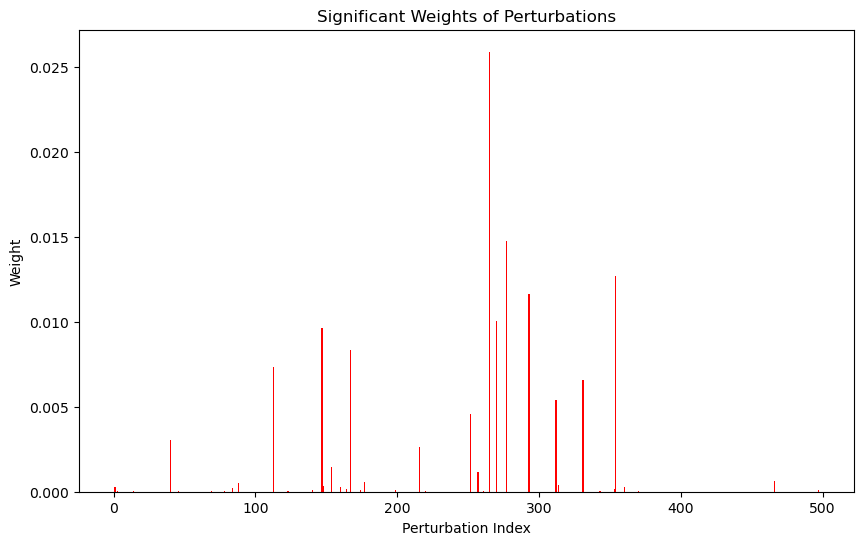

In [262]:
# Visualizing the impact

# Plot significant weights
plt.figure(figsize=(10, 6))
plt.bar(significant_indices, significant_weights, color='r')
plt.xlabel('Perturbation Index')
plt.ylabel('Weight')
plt.title('Significant Weights of Perturbations')
plt.show()

In [263]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Check the shape of X_array
X_array = X.values
print("Shape of X_array:", X_array.shape)

# Print significant indices
print("Significant indices:", significant_indices)

# Filter out invalid indices
valid_indices = [index for index in significant_indices if index < X_array.shape[1]]
print("Valid indices:", valid_indices)

# Extract significant perturbations using valid indices
X_significant = X_array[:, valid_indices]

# Train the linear regression model
model_significant = LinearRegression()
model_significant.fit(X_significant, y)

# Predict using the model
y_pred_significant = model_significant.predict(X_significant)

# Calculate performance metrics
mse_significant = mean_squared_error(y, y_pred_significant)
r2_significant = r2_score(y, y_pred_significant)

mse_significant, r2_significant



Shape of X_array: (284807, 30)
Significant indices: [  1   3  14  19  28  37  40  45  46  56  60  66  69  73  76  78  80  84
  88  92 107 113 123 128 135 140 147 148 149 154 160 163 164 166 167 174
 177 184 185 188 199 203 205 206 207 216 220 234 245 246 249 251 252 255
 257 261 265 270 274 277 280 281 284 293 295 298 299 312 313 314 331 340
 343 350 353 354 355 360 370 377 381 384 386 392 403 411 412 418 424 427
 428 430 432 434 459 461 466 468 475 477 480 490 497]
Valid indices: [1, 3, 14, 19, 28]


(0.0016881235158495418, 0.021094739418525243)

The MSE indicates how much the predicted values deviate, on average, from the actual values. Since this value is close to zero, it suggests that the model's predictions are quite close to the actual values.

The low r2_significant value suggests that the significant perturbations identified are not very effective in explaining the variation in the target variable.

Significant Indices: [  1   3  14  19  28  37  40  45  46  56  60  66  69  73  76  78  80  84
  88  92 107 113 123 128 135 140 147 148 149 154 160 163 164 166 167 174
 177 184 185 188 199 203 205 206 207 216 220 234 245 246 249 251 252 255
 257 261 265 270 274 277 280 281 284 293 295 298 299 312 313 314 331 340
 343 350 353 354 355 360 370 377 381 384 386 392 403 411 412 418 424 427
 428 430 432 434 459 461 466 468 475 477 480 490 497]
Significant Weights: [2.73346999e-04 4.08325746e-05 4.32370835e-05 2.43718726e-12
 2.07333636e-08 2.06026199e-12 3.02838082e-03 1.59420920e-11
 1.60970119e-05 1.58780170e-08 1.69952656e-07 8.70160331e-10
 5.46546675e-05 2.73936785e-08 1.26576234e-08 2.26996360e-05
 9.33758826e-12 2.03073071e-04 5.11413896e-04 1.89756662e-11
 7.48789410e-06 7.35135665e-03 1.61106650e-05 2.11265943e-12
 1.80242941e-08 1.11142259e-04 9.62259274e-03 3.54930414e-04
 7.15830625e-08 1.44300549e-03 3.06772797e-04 5.86332134e-07
 1.55630766e-04 1.33541041e-06 8.33949547e-03 8.709

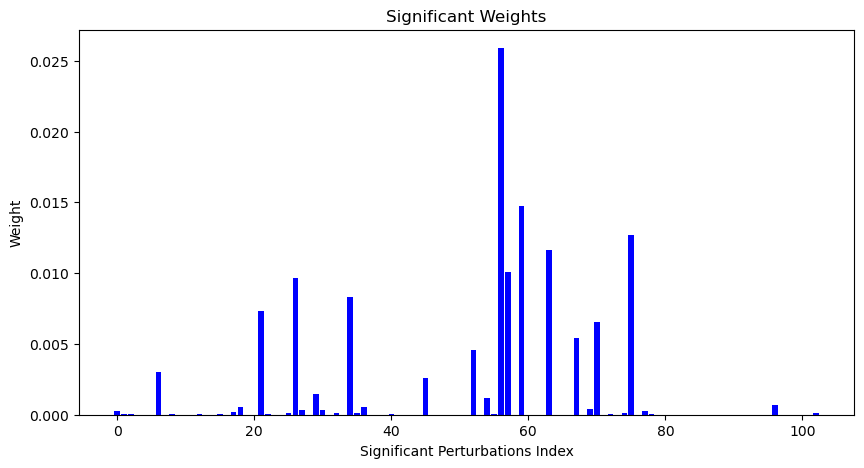

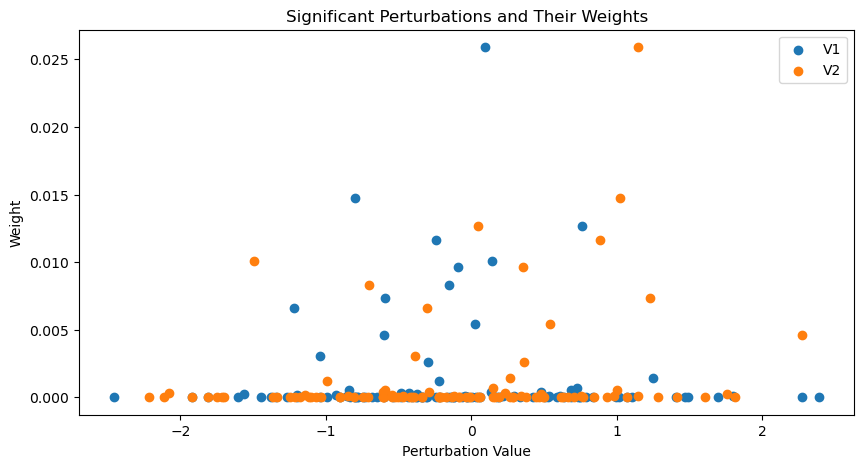

In [265]:
# Define a threshold to filter significant weights
threshold = 1e-12



feature_names = ["V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13"
                "V14", "V15", "V16", "V17", "V18", "V19", "V20", "V21", "V22", "V23", "V24", "V25"
                "V26", "V27", "V28", "scaled_amount", "scaled_time"]  
X_lime = np.random.normal(0, 1, size=(len(weights2), len(feature_names)))  # Example perturbations

# Extract indices of significant weights
significant_indices = np.where(weights2 > threshold)[0]

# Extract significant weights and their corresponding perturbations
significant_weights = weights2[significant_indices]
significant_perturbations = X_lime[significant_indices]

# Display significant weights and their indices
print("Significant Indices:", significant_indices)
print("Significant Weights:", significant_weights)

# Bar chart for significant weights
plt.figure(figsize=(10, 5))
plt.bar(range(len(significant_weights)), significant_weights, color='blue')
plt.xlabel('Significant Perturbations Index')
plt.ylabel('Weight')
plt.title('Significant Weights')
plt.show()

# Scatter plot for significant perturbations and weights
plt.figure(figsize=(10, 5))

# Assuming 2D perturbations for simplicity, extend this for more dimensions if needed
for i, feature_name in enumerate(feature_names[:2]):  # Adjust the range if you have more features
    plt.scatter(significant_perturbations[:, i], significant_weights, label=feature_name)

plt.xlabel('Perturbation Value')
plt.ylabel('Weight')
plt.title('Significant Perturbations and Their Weights')
plt.legend()
plt.show()

In [268]:
# Create a DataFrame for tabular explanation
data = {
    "Perturbation Index": significant_indices,
    "Weight": significant_weights
}

# Add each feature's perturbation values
for i, feature_name in enumerate(feature_names):
    data[feature_name] = significant_perturbations[:, i]

# Add coefficients to the DataFrame
data["Coefficient"] = np.tile(coefs, (len(significant_weights), 1))


# Display the DataFrame
print("Tabular Explanation for SMILE:")
print(df)

Tabular Explanation for SMILE:
        scaled_amount  scaled_time         V1         V2        V3        V4  \
0            1.783274    -0.994983  -1.359807  -0.072781  2.536347  1.378155   
1           -0.269825    -0.994983   1.191857   0.266151  0.166480  0.448154   
2            4.983721    -0.994972  -1.358354  -1.340163  1.773209  0.379780   
3            1.418291    -0.994972  -0.966272  -0.185226  1.792993 -0.863291   
4            0.670579    -0.994960  -1.158233   0.877737  1.548718  0.403034   
...               ...          ...        ...        ...       ...       ...   
284802      -0.296653     1.034951 -11.881118  10.071785 -9.834783 -2.066656   
284803       0.038986     1.034963  -0.732789  -0.055080  2.035030 -0.738589   
284804       0.641096     1.034975   1.919565  -0.301254 -3.249640 -0.557828   
284805      -0.167680     1.034975  -0.240440   0.530483  0.702510  0.689799   
284806       2.724796     1.035022  -0.533413  -0.189733  0.703337 -0.506271   

        

In [253]:
import statsmodels.api as sm

# Add a constant to the model (intercept)
X_significant_with_const = sm.add_constant(X_significant)

# Fit the model using statsmodels
model_stats = sm.OLS(y, X_significant_with_const).fit()

# Get the summary of the model
model_stats_summary = model_stats.summary()

model_stats_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Class   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     813.0
Date:                Sun, 30 Jun 2024   Prob (F-statistic):               0.00
Time:                        10:21:34   Log-Likelihood:             5.0318e+05
No. Observations:              284807   AIC:                        -1.006e+06
Df Residuals:                  284803   BIC:                        -1.006e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018   7.92e-05     23.111      0.000       0.002       0.002
x1            -0.0009      0.000     -6.261      0.000      -0.001      -0.001
x2             0.0023   4.69e-05     48.857      0.000       0.002       0.002
x3            -0.0002    7.8e-05     -2.857      0.004      -0.000   -6.99e-05
==============================================================================
Omnibus:                   664874.383   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3807791943.591
Skew:                          23.702   Prob(JB):                         0.00
Kurtosis:                     567.470   Cond. No.                         3.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Key Elements of the Output

## Model Summary:

R-squared and Adjusted R-squared: 0.008

R-squared: Indicates that 8% of the variability in the dependent variable Class is explained by the independent variables x1, x2, x3, and x4.

## Statistical Significance:

### Coefficients: 
Show the impact of each independent variable on the dependent variable. For instance:
x1 has a negative coefficient, meaning an increase in x1 is associated with a decrease in the dependent variable.
x3 and x4 have positive coefficients, indicating an increase in these variables is associated with an increase in the dependent variable.

### F-statistic: 
Indicates that the overall regression model is significant (p-value is essentially 0).

# Interpretation

The OLS regression results indicate that there is some degree of multicollinearity among the features, but the model still provides a statistically significant fit to the data. The individual coefficients' significance shows how each feature contributes to the prediction.